In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 모델 학습준비

## 모듈 로드

In [2]:
 %tensorflow_version 2.x

import tensorflow as tf

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
print("Module Loaded.")
print("TensorFlow Version :{}".format(tf.__version__))
print("NumPy Version :{}".format(np.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

# set auto tune
AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.
Module Loaded.
TensorFlow Version :2.1.0
NumPy Version :1.17.5
Matplotlib Version :3.1.2


In [0]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴  
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name

## 데이터로드

In [6]:
!unzip /content/drive/My\ Drive/tf2/z_data/asirra_fixed.zip

Archive:  /content/drive/My Drive/tf2/z_data/asirra_fixed.zip
   creating: asirra/
   creating: asirra/test/
   creating: asirra/test/cat/
  inflating: asirra/test/cat/cat.10.jpg  
  inflating: asirra/test/cat/cat.100.jpg  
  inflating: asirra/test/cat/cat.1000.jpg  
  inflating: asirra/test/cat/cat.10000.jpg  
  inflating: asirra/test/cat/cat.10002.jpg  
  inflating: asirra/test/cat/cat.10005.jpg  
  inflating: asirra/test/cat/cat.10006.jpg  
  inflating: asirra/test/cat/cat.10007.jpg  
  inflating: asirra/test/cat/cat.10008.jpg  
  inflating: asirra/test/cat/cat.10009.jpg  
  inflating: asirra/test/cat/cat.1001.jpg  
  inflating: asirra/test/cat/cat.10010.jpg  
  inflating: asirra/test/cat/cat.10012.jpg  
  inflating: asirra/test/cat/cat.10018.jpg  
  inflating: asirra/test/cat/cat.10019.jpg  
  inflating: asirra/test/cat/cat.10020.jpg  
  inflating: asirra/test/cat/cat.10021.jpg  
  inflating: asirra/test/cat/cat.10023.jpg  
  inflating: asirra/test/cat/cat.10025.jpg  
  inflating: 

In [0]:
import pathlib
train_data_dir_cwd=pathlib.Path('/content/asirra/train')
test_data_dir_cwd=pathlib.Path('/content/asirra/test')

In [6]:

image_count_cwd, CLASS_NAMES_cwd = check_dir(train_data_dir_cwd)
test_image_count_cwd, CLASS_NAMES_cwd = check_dir(test_data_dir_cwd)
print('image_count: {}\nclasses: {}'.format(image_count_cwd, CLASS_NAMES_cwd))
print('image_count: {}\nclasses: {}'.format(test_image_count_cwd, CLASS_NAMES_cwd))

image_count: 12500
classes: ['cat' 'dog']
image_count: 12500
classes: ['cat' 'dog']


## image_data_generator 준비

In [9]:
datagen_2=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
generator_2=datagen_2.flow_from_directory(
    directory=str(train_data_dir_cwd),
    batch_size=12500,
    shuffle=False,
    target_size=(150, 150)
)
generator_2_test=datagen_2.flow_from_directory(
    directory=str(test_data_dir_cwd),
    batch_size=12500,
    shuffle=True,
    target_size=(150, 150)
)


Found 12500 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.


# 자체개발 모델

In [0]:
generator_2_self_train=datagen_2.flow_from_directory(
    directory=str(train_data_dir_cwd),
    batch_size=512,
    shuffle=True,
    target_size=(150, 150)
)
generator_2_self_test=datagen_2.flow_from_directory(
    directory=str(test_data_dir_cwd),
    batch_size=512,
    shuffle=True,
    target_size=(150, 150)
)

Found 12500 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.


In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras import models
def model_function():
    input_= layers.Input(shape=( generator_2.image_shape))                   
    x=layers.Conv2D(64,3,padding='same',activation='relu',name='conv32')(input_)
    x=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=layers.Conv2D(32,3,padding='same',activation='relu',name='conv32_2')(x)
    x=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=layers.Conv2D(32,3,padding='same',activation='relu',name='conv32_3')(x)
    x=layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x=layers.Flatten()(x)
    x=layers.Dense(64,activation='relu')(x)
    x=layers.Dropout(0.5)(x)
    x=layers.Dense(32,activation='relu')(x)
    prediction = layers.Dense(2,activation='softmax')(x)
    # return model
    return models.Model(input_, prediction)

In [0]:
model=model_function()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv32 (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv32_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv32_3 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0     

In [0]:
%%time
history=model.fit(generator_2_self_train,epochs=20,validation_data=generator_2_self_test,validation_steps=5)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 5 steps
Epoch 1/20
25/25 [==============================] - 47s 2s/step - loss: 0.6916 - accuracy: 0.5258 - val_loss: 0.6764 - val_accuracy: 0.5453
Epoch 2/20
25/25 [==============================] - 47s 2s/step - loss: 0.6708 - accuracy: 0.5754 - val_loss: 0.6726 - val_accuracy: 0.5809
Epoch 3/20
25/25 [==============================] - 48s 2s/step - loss: 0.6415 - accuracy: 0.6192 - val_loss: 0.6201 - val_accuracy: 0.6340
Epoch 4/20
25/25 [==============================] - 45s 2s/step - loss: 0.6081 - accuracy: 0.6679 - val_loss: 0.5909 - val_accuracy: 0.7145
Epoch 5/20
25/25 [==============================] - 42s 2s/step - loss: 0.5605 - accuracy: 0.7153 - val_loss: 0.5681 - val_accuracy: 0.7121
Epoch 6/20
25/25 [==============================] - 43s 2s/step - loss: 0.5418 - accuracy: 0.7301 - val_loss: 0.5425 - val_accuracy: 0.7281
Epoch 7/20
25/25 [==============================] - 43s 2s/step - los

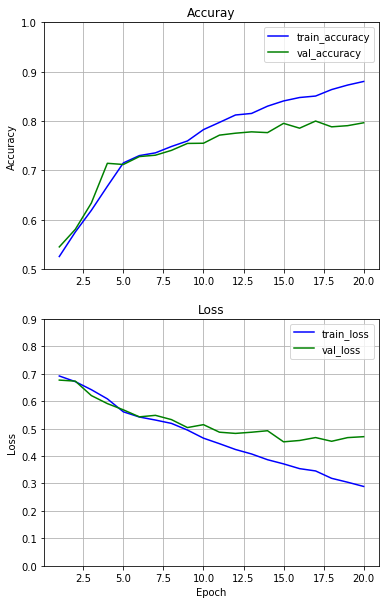

CPU times: user 465 ms, sys: 12 ms, total: 477 ms
Wall time: 499 ms


In [0]:
%%time
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')

plt.grid(True)
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 0.9])
plt.legend(loc='best')
plt.show()

In [0]:
model.save('/content/self_model.h5')

# transfer model

## 병목만들기

In [0]:
vgg_model_2=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(150,150,3)))


58892288/58889256 [==============================] - 2s 0us/step


In [0]:
%%time
img_train,label_train=generator_2.next()
bottleneck_train=vgg_model_2.predict(img_train)

CPU times: user 44.1 s, sys: 9.85 s, total: 54 s
Wall time: 52 s


In [0]:
%%time
img_test,label_test=generator_2_test.next()
bottleneck_test=vgg_model_2.predict(img_test)

CPU times: user 43.4 s, sys: 8.16 s, total: 51.6 s
Wall time: 49.7 s


## new Danse Layer

In [0]:
model_bt = tf.keras.Sequential()
model_bt.add(tf.keras.layers.Flatten())
model_bt.add(tf.keras.layers.Dense(256, activation='relu'))
model_bt.add(tf.keras.layers.Dropout(0.5))
model_bt.add(tf.keras.layers.Dense(2, activation='softmax'))



In [0]:
model_bt.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics=['accuracy'])

## fit with bottelneck

In [0]:
model_bt.fit(bottleneck_train, label_train,
          epochs=10,
          batch_size=512,validation_data=(bottleneck_test,label_test)
          )

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 1s 69us/sample - loss: 0.8783 - accuracy: 0.6851 - val_loss: 0.3454 - val_accuracy: 0.8463
Epoch 2/10
12500/12500 [==============================] - 0s 30us/sample - loss: 0.3204 - accuracy: 0.8634 - val_loss: 0.2704 - val_accuracy: 0.8845
Epoch 3/10
12500/12500 [==============================] - 0s 30us/sample - loss: 0.2642 - accuracy: 0.8901 - val_loss: 0.2387 - val_accuracy: 0.8974
Epoch 4/10
12500/12500 [==============================] - 0s 30us/sample - loss: 0.2347 - accuracy: 0.9048 - val_loss: 0.2281 - val_accuracy: 0.9022
Epoch 5/10
12500/12500 [==============================] - 0s 30us/sample - loss: 0.2166 - accuracy: 0.9127 - val_loss: 0.2331 - val_accuracy: 0.8978
Epoch 6/10
12500/12500 [==============================] - 0s 29us/sample - loss: 0.1964 - accuracy: 0.9227 - val_loss: 0.2149 - val_accuracy: 0.9102
Epoch 7/10
12500/12500 [==============================] 

## save weigth

In [0]:
model_bt.save_weights('/content/save_weight')

## marge model

In [0]:
vgg_model_2=tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(150,150,3)))

existing_model = tf.keras.Sequential()
existing_model.add(tf.keras.layers.Flatten())
existing_model.add(tf.keras.layers.Dense(256, activation='relu'))
existing_model.add(tf.keras.layers.Dropout(0.5))
existing_model.add(tf.keras.layers.Dense(2, activation='softmax'))

existing_model.build(vgg_model_2.output_shape)

In [0]:
existing_model(vgg_model_2.output)

exvgg_model=tf.keras.Model(inputs=vgg_model_2.input,outputs=existing_model.output)

In [0]:
exvgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
for layer in vgg_model_2.layers :
  layer.trainable=False

In [0]:
existing_model.load_weights('/content/save_weight')

In [0]:
exvgg_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
exvgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

## 평가

In [0]:
generator_2_test_val=datagen_2.flow_from_directory(
    directory=str(test_data_dir_cwd),
    batch_size=125,
    shuffle=True,
    target_size=(150, 150)
)


Found 12500 images belonging to 2 classes.


In [0]:
exvgg_model.evaluate(generator_2_test_val)

  ...
    to  
  ['...']
100/100 [==============================] - 36s 364ms/step - loss: 0.2092 - accuracy: 0.9127


[0.20919882617890834, 0.91272]

## 모델 저장

In [0]:
exvgg_model.save('/content/transfer_model.h5')

In [0]:
del model_bt

In [0]:
del exvgg_model

# 모델 변환

In [0]:
import tensorflow.lite as tflite
from tensorflow.keras.models import load_model

In [0]:
model2 = load_model('/content/self_model.h5')

In [0]:
model2 = load_model('/content/transfer_model.h5')

In [0]:
converter=tflite.TFLiteConverter.from_keras_model(model2)
tfliteModel=converter.convert()
open('tflitemodel.tflite','wb').write(tfliteModel)

## 모델 압축 사이즈 미리보기

zip파일로 압축할 경우 사이즈가 작아져 업로드& 다운로드시에 조금더 빨라질수 있다.

In [0]:
import zipfile
import tempfile

In [0]:
model2 = load_model('/content/drive/My Drive/5_6.h5')

In [11]:
converter=tflite.TFLiteConverter.from_keras_model(model2)
tflite_model_file=converter.convert()
open('tflitemodel.tflite','wb').write(tflite_model_file)

67257488

In [15]:
tflite_model_file = '/content/tflitemodel.tflite'
_, zip_tflite = tempfile.mkstemp('.zip')
with zipfile.ZipFile(zip_tflite, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(tflite_model_file)
print("Size of the tflite model before compression: %.2f Mb" 
      % (os.path.getsize(tflite_model_file) / float(2**20)))
print("Size of the tflite model after compression: %.2f Mb" 
      % (os.path.getsize(zip_tflite) / float(2**20)))

Size of the tflite model before compression: 64.14 Mb
Size of the tflite model after compression: 59.53 Mb


## Post-training quantize the TensorFlow Lite model

여러 옵션의 최적화를 통해 iot에 적합한 모델로 변환가능

In [0]:
model2 = load_model('/content/self_model.h5')

In [16]:
converter_quan=tflite.TFLiteConverter.from_keras_model(model2)
converter_quan.optimizations = [tflite.Optimize.DEFAULT] # 최적화 옵션 선택가능
converter_quan.target_spec.supported_types = [tf.float16] # 16bit 부동소수점으로 수정
tfliteModel_quan=converter_quan.convert()
open('tfliteModel_quan.tflite','wb').write(tfliteModel_quan)

33635792

# 모델 가지치기 (추가 연구 필요)

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras 관련 자료들

개요 : 의미없는 연결을 제거하면서 모델의 용량과 계산량을 줄이는 기법

주의! 학습이 완료된 후 시행해야한다

![대체 텍스트](https://miro.medium.com/max/1532/0*iNI8Oc80Eunm8NgI)
![대체 텍스트](https://github.com/hoo0681/raspi4withTF/blob/master/%EC%A3%BC%EC%84%9D%202020-01-29%20221658.png?raw=true)

In [0]:
from tensorflow_model_optimization.sparsity import keras as sparsity


In [10]:

generator_pruning_train=datagen_2.flow_from_directory(
    directory=str(train_data_dir_cwd),
    batch_size=512,
    shuffle=True,
    target_size=(150, 150)
)
generator_pruning_test=datagen_2.flow_from_directory(
    directory=str(test_data_dir_cwd),
    batch_size=512,
    shuffle=True,
    target_size=(150, 150)
)


Found 12500 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.


## 자체개발 모델 재학습

In [0]:

pruned_model=model_function()
pruned_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
pruned_model.fit(generator_pruning_train,validation_data=generator_pruning_test,epochs=12)

## prune_low_magnitude

weight tensor의 initial_sparsity * 100 (%) 부터 시작해서 점차적으로 final_sparsity * 100(%)를 제거한다 

각 작업은 begin_step부터 end_step 까지 frequency간격으로 이루어진다.

이러한 요소는 hyper_parameter로 성능과 용량, 속도의 타협점을 찾아야한다.

아래는 기본적인 사용법의 예시이며 최적의 구성과는 거리가 있다

### pruning_schedule 설정

학습종료 후 2 epoch 에 걸쳐 90%의 연결을 제거하고 10step마다 작업한다.

In [71]:
import numpy as np

epochs = 2
num_train_samples = generator_pruning_train.samples
end_step = np.ceil(1.0 * num_train_samples / generator_pruning_train.batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 50


In [0]:
pruning_schedule= sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=10)

### prune_low_magnitude에 model 넣기



 prune_low_magnitude에 model 을 넣으면 해당 모델의 모든 layer에 pruning이 적용되며 layer별로 적용하고 싶다면



```
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=2000,
                                                   end_step=end_step,
                                                   frequency=100)
}
pruned_model = tf.keras.Sequential([
    sparsity.prune_low_magnitude(
        l.Conv2D(32, 5, padding='same', activation='relu'),
        input_shape=input_shape,
        **pruning_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.BatchNormalization(),
    sparsity.prune_low_magnitude(
        l.Conv2D(64, 5, padding='same', activation='relu'), **pruning_params),
    l.MaxPooling2D((2, 2), (2, 2), padding='same'),
    l.Flatten(),
    sparsity.prune_low_magnitude(l.Dense(1024, activation='relu'),
                                 **pruning_params),
    l.Dropout(0.4),
    sparsity.prune_low_magnitude(l.Dense(num_classes, activation='softmax'),
                                 **pruning_params)
])
```
와 같이 layer를 prune_low_magnitude로 쌓야한다


In [0]:
model_for_pruning = sparsity.prune_low_magnitude(pruned_model, pruning_schedule=pruning_schedule)


In [0]:
model_for_pruning.summary()

In [0]:
model_for_pruning.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

### pruning 적용하기

keras에서 사용하는 방법과 약간 다른 것으로 보이는데 callback함수를 사용하여 적용 해야한다.

In [0]:
callbacks = [
    sparsity.UpdatePruningStep()
]

In [70]:
model_for_pruning.fit(generator_pruning_train,validation_data=generator_pruning_test,epochs=2,callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 25 steps
Epoch 1/2
25/25 [==============================] - 68s 3s/step - loss: 0.4891 - accuracy: 0.7718 - val_loss: 0.5922 - val_accuracy: 0.7090
Epoch 2/2
25/25 [==============================] - 65s 3s/step - loss: 0.6395 - accuracy: 0.6374 - val_loss: 0.6449 - val_accuracy: 0.6414


모델 변환은 위에서 나온 것 처럼 진행하면 된다.

### 기타 tensorboard와 함께 사용하기, 심화 활용은 다음 링크를 참조한다.

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras#train_a_pruned_mnist
